**(S)ARIMA univariate model for the prediction of meteorological time series data.**

# **IMPORT LIBRARIES**

In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px
import statsmodels.api as sm
import matplotlib.pyplot as plt

from math import sqrt
from pandas import DataFrame
from datetime import datetime
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot

from statsmodels.tsa.ar_model import AutoReg # AR
from statsmodels.tsa.arima.model import ARIMA #ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX # SARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score, mean_absolute_percentage_error

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 5)
plt.style.use('default')

# **DATA MANIPULATION**

In [ ]:
#--- LOAD DATA ---#
location = 'TIME-SERIES-Diario-13-23.csv'  ## DAILY DATA
# location = 'TIME-SERIES-Mensual-86-23.csv' ## MONTHLY DATA

data = pd.read_csv(location, delimiter=',', index_col='Fecha', header=0, parse_dates=True)
data.head()

,Año,Mes,Dia,Tｰ Media,TｰMaxima,TｰMinima,Lluvia,%Humedad
Fecha,,,,,,,,
2013-01-01,2013,Ene,1,12.038,18.022,7.344,0.956,73.676
2013-01-02,2013,Ene,2,12.224,18.000,8.078,3.600,74.553
2013-01-03,2013,Ene,3,11.902,17.822,7.667,9.933,76.719
2013-01-04,2013,Ene,4,10.906,16.778,7.122,8.800,79.117
2013-01-05,2013,Ene,5,11.146,16.267,7.211,4.956,79.746


In [ ]:
# RENAME COLUMNS NAME
data = data.rename(columns={"Tｰ Media": "Temp_media", "TｰMaxima": "Temp_max", "TｰMinima": "Temp_min", "Lluvia": "Precipitacion", "%Humedad": "Humedad"})

In [ ]:
#--- SELECT TARGET VARIABLE ---#
# We are dropping all columns except 'Temp_max' to isolate the target variable.
data = data.drop(["Año", "Dia", "Mes", "Temp_media", "Humedad", "Precipitacion", "Temp_min"], axis=1) # DAILY MAXIMUM TEMPERATURE DATA FRAME
# data = data.drop(["Año", "Mes", "Temp_media", "Humedad", "Temp_min", "Precipitacion"], axis=1)# # MONTHLY MAXIMUM TEMPERATURE DATA FRAME

# Display the first few rows of the dataframe after dropping columns
data.head()

,Temp_max
Fecha,
2013-01-01,18.022
2013-01-02,18.000
2013-01-03,17.822
2013-01-04,16.778
2013-01-05,16.267


In [ ]:
#Check for null values
data.isnull().any()

In [ ]:
# DROP NULL VALUES
data.dropna(inplace=True)

In [ ]:
# DATA SET INFORMATION
data.info()

In [ ]:
# Basic descriptive stats
data.describe()

# **DATA PREPARATION**

## **DATA SPLIT**

In [ ]:
# split into train and test sets
X = data
size = int(len(X) * 0.80)
train, test = X[0:size], X[size:len(X)]

In [ ]:
train.head(2)

In [ ]:
test.head(2)

# **MODEL SETUP**

In [ ]:
#@title SARIMA Configuration
model = SARIMAX(train['Temp_max'], order=(2, 0, 1),seasonal_order=(2,1,2,15))

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
#@title Model Train
model = model.fit()

In [ ]:
#@title SARIMA summary
# summary of fit model
print(model.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                Temp_max   No. Observations:                 2912
Model:             SARIMAX(2, 0, 1)x(2, 1, [1, 2], 15)   Log Likelihood               -5724.981
Date:                                 Mon, 07 Jul 2025   AIC                          11465.962
Time:                                         16:39:26   BIC                          11513.733
Sample:                                     01-01-2013   HQIC                         11483.176
                                          - 12-21-2020                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4595      0.020     72.840      0.000       1.420       1

In [ ]:
#@title SARIMA Prediction
# Prediction
pred_SARIMA = model.predict(len(train.Temp_max),len(test.Temp_max)+len(train.Temp_max)-1)
print(pred_SARIMA)

2020-12-22    19.473802
2020-12-23    19.451841
2020-12-24    19.334057
2020-12-25    19.203562
2020-12-26    19.286295
                ...    
2023-08-15    17.955529
2023-08-16    17.855441
2023-08-17    18.213748
2023-08-18    18.291697
2023-08-19    18.295433
Freq: D, Name: predicted_mean, Length: 971, dtype: float64


In [ ]:
#@title SARIMA Evaluation
# Calculate the metrics
mae = mean_absolute_error(test['Temp_max'], pred_SARIMA)
rmse = mean_squared_error(test['Temp_max'], pred_SARIMA) ** 0.5
mse = mean_squared_error(test['Temp_max'], pred_SARIMA)
mape = mean_absolute_percentage_error(test['Temp_max'], pred_SARIMA) * 100

# PRINT METRICS
print(f'TEST - RMSE: {rmse:.5f}, MAE: {mae:.5f}, MAPE: {mape:.5f}%')

TEST - RMSE: 2.22521, MAE: 1.72835, MAPE: 9.93256%


# **VISUALIZATION**

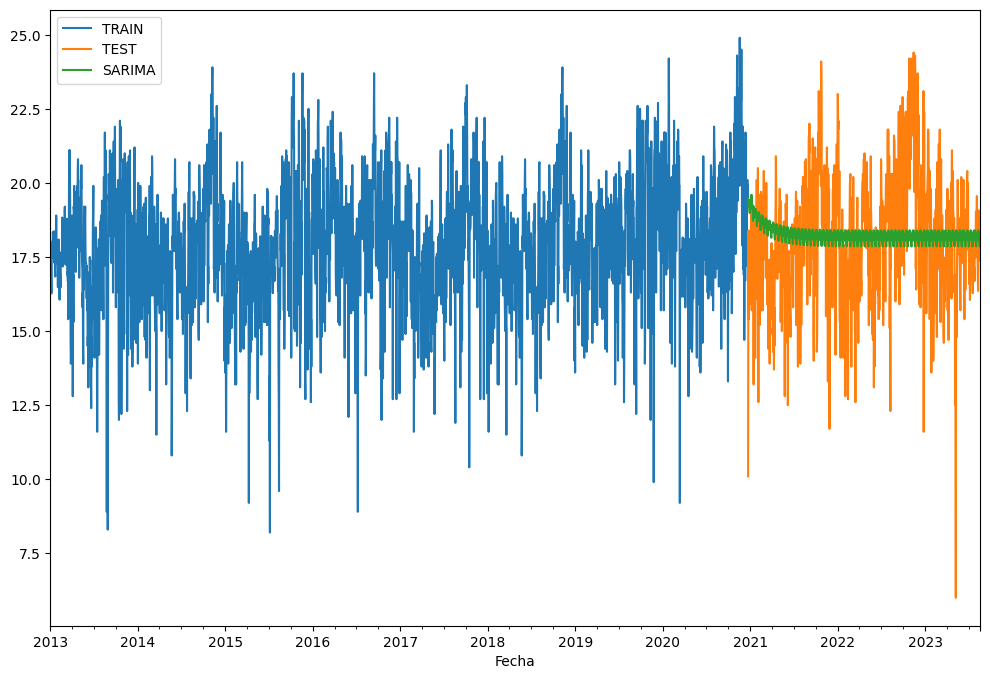

In [ ]:
# PLOT FORECASTING
train['Temp_max'].plot(legend=True, label='TRAIN')
test['Temp_max'].plot(legend=True, label='TEST', figsize=(12,8))
pred_SARIMA.plot(legend=True, label='SARIMA');

<Axes: xlabel='Fecha'>

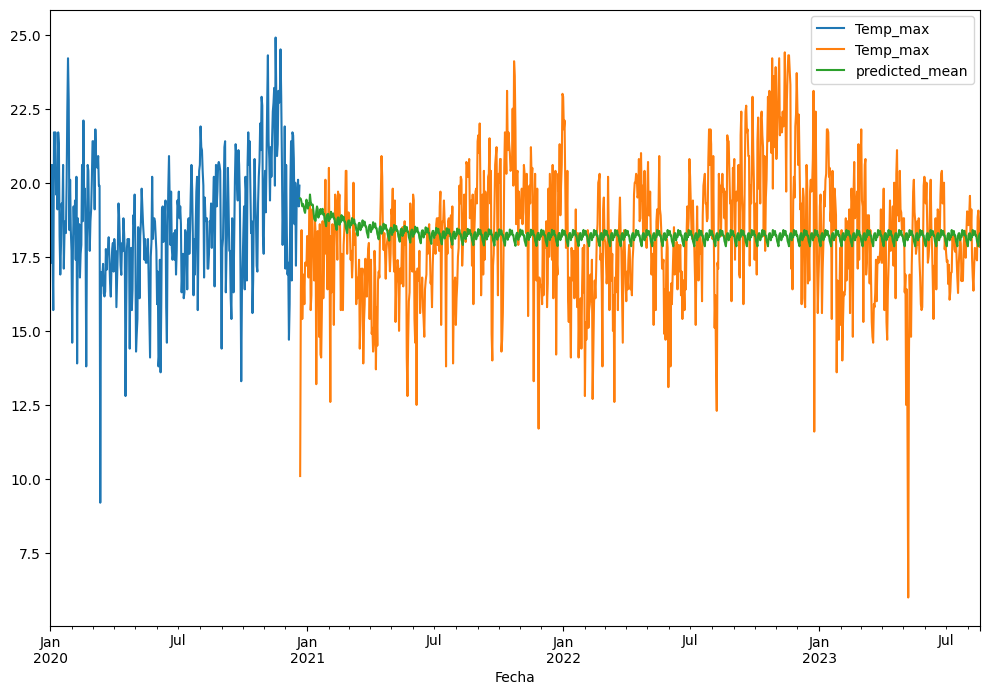

In [ ]:
# Close Visualization
train['Temp_max']['2020-01-01':].plot(figsize = (12,8), legend = True)
test['Temp_max'].plot( legend = True)
pred_SARIMA.plot(legend = True)

# **FUTURE PREDICTIONS**